# DeepArk Supplemental Figure S9 Notebook
- This notebook reproduces supplemental figure S9 from the manuscript.
- Note that reproducing this figure requires processing the raw RNA-seq data from SRA, and predicting regulatory activity for a number of loci. As such, this is rather time intensive.

## Setup

In [1]:
%matplotlib inline
import pandas
import numpy
import os
import pickle
import h5py
import scipy.stats
import time
import re
import itertools
from functools import reduce

pandas.options.display.max_rows = 6

import collections
import pyfaidx
import matplotlib
import matplotlib.pyplot as plt
import pyBigWig
import copy
import tabix
import bx.intervals.intersection
import weakref
print("Finished.")

Finished.


## Plot Configuration

In [2]:
lw = 0.3
lc = "black"
col_width = 0.6

In [3]:
def reset_plot_config():
#     seaborn.set()
    matplotlib.rcParams.update(matplotlib.rcParamsDefault)

    d = {"lines.linewidth": 0.4,
        "axes.linewidth": 0.4,
        "ytick.major.width": 0.4,
        "xtick.major.width": 0.,
        "xtick.major.size": 3,
        "ytick.major.size": 3,
        "ytick.minor.width": 0.4,
        "xtick.minor.width": 0.8,
        "ytick.minor.size": 1.6,
        "xtick.minor.size": 1,
        "xtick.major.pad": 0,
        "ytick.major.pad": 0}

    for k, v in d.items():
        matplotlib.rcParams[k] = v

    matplotlib.rcParams["figure.dpi"] = 300
    matplotlib.rcParams["axes.facecolor"] = "none"
    matplotlib.rcParams["figure.facecolor"] = "none"
    matplotlib.rcParams["xtick.labelsize"] = 6
    matplotlib.rcParams["ytick.labelsize"] = 6
    matplotlib.rcParams["axes.labelsize"] = 6
    matplotlib.rcParams['axes.titlesize'] = 6
    matplotlib.rcParams['legend.fontsize'] = 6
    matplotlib.rcParams['axes.titlepad'] = 4
    matplotlib.rcParams['axes.ymargin'] = 0
    matplotlib.rcParams['axes.xmargin'] = 0
    for x in ["left", "right", "top", "bottom"]:
        matplotlib.rcParams["figure.subplot.{}".format(x)] = 0.08 if x in {"left",  "bottom"} else 0.99

    matplotlib.rcParams["legend.fancybox"] = False
    # Legend settings:    
    d = {"legend.borderpad" : 0.4,  
        "legend.labelspacing" : 0.0,  
        "legend.handlelength" : 2.0,  
        "legend.handleheight" : 0.7,
        "legend.handletextpad" : 0.,
        "legend.borderaxespad" : 0.5,
        "legend.fontsize": 6,
        "legend.borderpad": 0.4}

    #legend.columnspacing}
    for k, v in d.items():
        matplotlib.rcParams[k] = v
        
reset_plot_config()

## Custom Genome Viewer Code

In [4]:
class ChainRecord(object):
    def __init__(self, *args):
        self.score, self.tName, self.tSize, self.tStrand, self.tStart, self.tEnd, self.qName, self.qSize, self.qStrand, self.qStart, self.qEnd, self.chain_id = args
        self.tIvals = list()
        self.qIvals = list()

def read_chain_file(path, max_gap=200):
    cur_chain_id = 0
    chains = list()
    curChain = tPos = qPos = None
    with open(path, "r") as read_file:
        for line in read_file:
            if line.startswith("##"): # Comments.
                continue
            elif line.startswith("chain"): # Start of chain block.
                if tPos is not None and qPos is not None:
                    raise ValueError("Found missing empty line between chain records!")
                line = line.split()[1:]
                for i in [0, 2, 4, 5, 7, 9, 10]:
                    line[i] = int(line[i])
                line[-1] = cur_chain_id
                cur_chain_id += 1
                curChain = ChainRecord(*line)
                tPos = curChain.tStart
                qPos = curChain.qStart
            elif line.strip() == "": # Gap between chain blocks.
                chains.append(curChain)
                tPos = qPos = curChain = None
            else: # If part of chain record.
                line = [int(x) for x in line.strip().split()]
                curChain.tIvals.append((tPos, tPos + line[0]))
                curChain.qIvals.append((qPos, qPos + line[0]))
                if len(line) > 1: # Non-final blocks.
                    if line[1] > max_gap or line[2] > max_gap: # If there's a gap between blocks above a certain size.
                        # Update the end points and size.
                        old_tEnd = curChain.tEnd
                        old_qEnd = curChain.qEnd
                        old_tSize = curChain.tSize
                        old_qSize = curChain.qSize
                        curChain.tEnd = tPos + line[0]
                        curChain.qEnd = qPos + line[0]
                        curChain.tSize = old_tSize - (old_tEnd - curChain.tEnd)
                        curChain.qSize = old_qSize - (old_qEnd - curChain.qEnd)
                        # Store chain.
                        chains.append(curChain)
                        # Build new chain.
                        tPos += line[0] + line[1]
                        qPos += line[0] + line[2]
                        curChain = ChainRecord(curChain.score,
                                               curChain.tName,
                                               old_tSize - curChain.tSize,
                                               curChain.tStrand,
                                               tPos,
                                               old_tEnd,
                                               curChain.qName,
                                               old_qSize - curChain.qSize,
                                               curChain.qStrand,
                                               qPos,
                                               old_qEnd,
                                               cur_chain_id)
                        cur_chain_id += 1
                    else:
                        tPos += line[0] + line[1]
                        qPos += line[0] + line[2]
                else:
                    qPos = tPos = None # Last alignment block in row.
    if tPos is not None and qPos is not None:
        raise ValueError("Found missing empty line at end of chain records!")
    return chains

In [5]:
def get_xy(x, y, s, axes):#, src_axes):
    if s == 'data':
        trans = axes.transData
        x = float(axes.convert_xunits(x))
        y = float(axes.convert_yunits(y))
        return trans.transform((x, y))
    elif isinstance(s, transforms.Transform):
        return s.transform((x, y))
    else:
        raise ValueError("{} is not a valid coordinate "
                         "transformation.".format(s))
        
        
def draw_rect(xy1, xy2, axesA, axesB, **kwargs):
    posA = get_xy(*xy1, "data", axesA)
    posB = get_xy(*xy2, "data", axesB)
    posA = axesA.transData.inverted().transform(posA)
    posB = axesA.transData.inverted().transform(posB)
    axesA.add_patch(matplotlib.patches.Rectangle(posA, posB[0] - posA[0], posB[1] - posA[1], fill=True,clip_on=False, **kwargs))
    
    
def draw_trapezoid(xy1, xy2, xy3, xy4, axesA, axesB, **kwargs):
    """
    1, 2 in bottom
    3, 4 in top
    """
    posA1 = get_xy(*xy1, "data", axesA)
    posA2 = get_xy(*xy2, "data", axesA)
    posB1 = get_xy(*xy3, "data", axesB)
    posB2 = get_xy(*xy4, "data", axesB)
    d = numpy.zeros((4, 2))
    for i, (x, y) in enumerate([posA1, posA2, posB1, posB2]):
        (x, y) = axesA.transData.inverted().transform((x, y))
        d[i, 0] = x
        d[i, 1] = y
    axesA.add_patch(matplotlib.patches.Polygon(d, closed=True, fill=True, clip_on=False, **kwargs))
    
    
# fig, axes = plt.subplots(2, 2, figsize=(9, 3), facecolor='none', edgecolor='k', gridspec_kw={'width_ratios': [3, 1]})
# axes[0, 0].set_xlim(-0.5, 2)
# axes[1, 0].set_ylim(-1, 2)
# axes[1, 0].set_xlim(-0.5, 1)
# # draw_rect((0, 0), (0.5, 0.5), axes[1, 0], axes[0, 0], color="blue")
# draw_trapezoid((0, 0), (0.5, 0.1), (0.6, 0.5), (0, 0.5), axes[1, 0], axes[0, 1], color="blue")
# plt.show()

In [14]:
Interval = collections.namedtuple("Interval", ["region", "start", "end"])
    
    
def draw_guide(x, ax, **kwargs):
    """ Draw a guide along the y axis."""
    i1, a1 = ax.get_ylim()
#     line1, = ax.plot([x, x],[i1, a1], transform=ax.get_xaxis_transform(), **kwargs)
    line1, = ax.plot([x, x],[i1, a1], **kwargs)

def draw_connection(x1, x2, ax1, ax2, **kwargs):
    """
    Draw a connection between plots.
    """
    _, a = ax1.get_ylim()
    i, _ = ax2.get_ylim()
    p = matplotlib.patches.ConnectionPatch((x1, a), (x2, i), coordsA='data', coordsB='data', axesA=ax1, axesB=ax2, **kwargs)
    ax1.add_artist(p)
    
        
class CoordinateTrack(object):
    """
    genome_file: path to genome.
    bin_size: width to use.
    offset: number to offset start of ticks by.
    tick_top: draw ticks on the top instead of the bottom.
    """
    def __init__(self, genome_file, offset=0, bin_size=1, tick_top=False, show_seq=False, fontdict={}, show_spines=[]):
        self._bin_size = bin_size
        self._tick_top = tick_top
        self._offset = offset
        self._genome = pyfaidx.Fasta(genome_file)
        self._chrom_length_dict = dict()
        for chrom in self._genome.keys():
            self._chrom_length_dict[chrom] = len(self._genome[chrom])
        self._fontdict = fontdict
        self._show_seq = show_seq
        if tick_top is True:
            tmp = list()
            if "bottom" in show_spines:
                tmp.append("top")
            if "top" in show_spines:
                tmp.append("bottom")
            for x in show_spines:
                if x not in {"top", "bottom"}:
                    tmp.append(x)
            show_spines = tmp
        self._show_spines = set(show_spines)

    def plot(self, ival, ax=None, fontdict={}):
        """
        ival: interval to plot at.
        """
        if ax is None:
            ax = plt.gca()
        for s in ["left", "right", "top", "bottom"]:
            ax.spines[s].set_visible(s in self._show_spines)
        if self._tick_top is True:
            ax.xaxis.tick_top()
            ax.xaxis.set_label_position('top') 
        ax.ticklabel_format(useOffset=False, style="plain")
        ax.set_yticks([])
        
        # Get xticks.
        i = self._offset + (ival.start - (ival.start % self._bin_size))
        a = ival.end + self._bin_size
        xticks = [x for x in numpy.arange(i, a, self._bin_size) if x >= ival.start and x < ival.end]
        ax.set_xticks(xticks)
#         ax.set_xticklabels(xticks)
        
        # Plot sequence.
        
        tmp = copy.deepcopy(self._fontdict)
        for k, v in fontdict.items():
            tmp[k] = v
        fontdict = tmp
        if self._show_seq is True:
            seq = self._genome[ival.region][ival.start:ival.end].seq.upper()
        else:
            seq = "".join([" "]*(ival.end - ival.start))
        for i, a in zip(range(ival.start, ival.end), seq):
            ax.text(i,
                    0,
                    a,
                    ha="center",
                    va="center",
                    fontdict=fontdict)
        ax.set_ylim(-.5, .5)
        

class SequenceTrack(object):
    """
    genome_file: path to genome.
    """
    def __init__(self, genome_file, fontdict={}, show_spines=[]):
        self._genome = pyfaidx.Fasta(genome_file)
        self._fontdict = fontdict
        self._show_spines = set(show_spines)
        
    def plot(self, ival, ax=None, fontdict={}):
        """
        ival: interval to plot at.
        """
        tmp = copy.deepcopy(self._fontdict)
        for k, v in fontdict.items():
            tmp[k] = v
        fontdict = tmp
        if ax is None:
            ax = plt.gca()
        for i, a in zip(range(ival.start, ival.end), self._genome[ival.region][ival.start:ival.end].seq.upper()):
            ax.text(i,
                    0,
                    a,
                    ha="center",
                    va="center",
                    fontdict=fontdict)
            ax.set_ylim(bottom=-0.7)
        for s in ["left", "right", "top", "bottom"]:
            ax.spines[s].set_visible(s in self._show_spines)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_ylim(-.5, .5)
        
                   
class SignalTrack(object):
    def __init__(self, bw_file, step_size=1, ylim=("auto", "auto"), show_spines=["bottom", "left"], show_labels=True, label="", fontdict={}, **kwargs):
        """
        bw_file: bigWig file with signal in it.
        ymin: either a minimum value, or "auto" to auto select based on current window, or "min" or "max" to get the global minimum and maximum.
        """
        self._bw_file = bw_file
        self._bw = pyBigWig.open(bw_file, "r")
        self.ylim = list()
        for v in list(ylim):
            if v == "auto":
                pass
            elif v == "max":
                v = self._bw.header()["maxVal"]
            elif v == "min":
                v = self._bw.header()["minVal"]
            else: # Assume int.
                pass 
            self.ylim.append(v)
        self.ylim = tuple(self.ylim)
        self._kwargs = kwargs
        self._show_spines = set(show_spines)
        self._show_labels = show_labels
        self._fontdict = fontdict
        self._label = label
        self._step_size = step_size
            
    def __del__(self):
        self._bw.close()
        
    def plot(self, ival, ax=None, fontdict={}, **kwargs):
        """
        ival: interval to plot at.
        """
        if ax is None:
            ax = plt.gca()
        tmp = copy.deepcopy(self._kwargs)
        for k, v in kwargs.items():
            tmp[k] = v
        kwargs = tmp
        if "width" in kwargs:
            s = ival.start - kwargs["width"]
            e = ival.end + kwargs["width"]
        else:
            s = ival.start
            e = ival.end
        
        xs = numpy.arange(s, e, self._step_size)
        
#         ys = []
#         other = list()
#         for x in xs.tolist():
#             tmp = self._bw.values(ival.region, x, x + self._step_size)
#             if not numpy.isnan(tmp):
#                 ys.append(tmp)
#                 other.append(x)
#         ys = numpy.array(ys).flatten()
#         xs = numpy.array(other)
            
        ys = [ 0. if numpy.isnan(x) else x for x in self._bw.values(ival.region, s, e)]
        if self._step_size != 1:
            tmp = []
            for i in range(len(xs)):
                p = xs[i] - s
                tmp.append(numpy.max(ys[p:(p + self._step_size)]))
            if self._step_size != 1:
                ys = scipy.stats.binned_statistic(numpy.arange(s, e), ys, "max", bins=xs.shape[0])
                ys = ys.statistic
            ys = numpy.array(tmp)
#         print(xs)
#         print(ys)
#         print(len(xs), len(ys))
            
        ax.bar(xs, ys, width=self._step_size, bottom=0, align="center", zorder=-1, **kwargs)
        for k, v in zip(["bottom", "top"], list(self.ylim)):
            if v != "auto":
                ax.set_ylim(**{k: v})
        i, a = ax.get_ylim()
        if i < 0 and a > 0:
            ax.axhline(0, lw=ax.yaxis.majorTicks[0]._width, color=ax.yaxis.majorTicks[0]._color)
        for s in ["right", "top", "bottom", "left"]:
            ax.spines[s].set_visible(s in self._show_spines)
        ax.set_xticks([])
        if self._show_labels is False:
            ax.set_yticks([])
            
        # Add units.
        tmp = copy.deepcopy(self._fontdict)
        for k, v in fontdict.items():
            tmp[k] = v
        fontdict = tmp
        ax.text(ax.get_xlim()[0],
                ax.get_ylim()[1] - 0.1 * (ax.get_ylim()[1] - ax.get_ylim()[0]),
                "[{},{}]".format(int(ax.get_ylim()[0]), int(ax.get_ylim()[1])), 
                verticalalignment="top",
                horizontalalignment="left",
                fontdict=fontdict)
        ax.text(ax.get_xlim()[0] - 25,
                ax.get_ylim()[1] - 0.5 * (ax.get_ylim()[1] - ax.get_ylim()[0]),
                self._label, 
                verticalalignment="center",
                horizontalalignment="right",
                fontdict=fontdict)
    
    
class SimpleGeneTrack(object):
    def __init__(self, gene_file, biotype="gene", show_spines=[], **kwargs):
        self._tabix = tabix.open(gene_file)
        self._biotype = biotype
        self._kwargs = kwargs
        self._show_spines = list(show_spines)
    
    def plot(self, ival, ax=None, **kwargs):
        if ax is None:
            ax = plt.gca()
        tmp = copy.deepcopy(self._kwargs)
        for k, v in kwargs.items():
            tmp[k] = v
        kwargs = tmp
        for gene in self._tabix.query(ival.region, ival.start, ival.end):
            biotype, start, end, _, strand  = gene[2:7]
            start = int(start)
            end = int(end)
            if biotype == self._biotype:
                start = max(ival.start, start)
                end = min(ival.end, end)
                ax.add_patch(matplotlib.patches.Rectangle((start, -.4), width=(end - start), height=.8, fill=True, **kwargs))
        for s in ["left", "right", "top", "bottom"]:
            ax.spines[s].set_visible(s in self._show_spines)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_ylim(-.5, .5)


class TranscriptTrack(object):
    """
    spine_between toggles if spines will be drawn between transcripts.
    """
    def __init__(self, gene_file, biotype="gene", show_spines=[], spine_between=False, **kwargs):
        self._tabix = tabix.open(gene_file)
        self._biotype = biotype
        self._kwargs = kwargs
        self._show_spines = set(show_spines)
        self._spine_between = spine_between
    
    def plot(self, ival, ax=None, **kwargs):
        if ax is None:
            ax = plt.gca()
        tmp = copy.deepcopy(self._kwargs)
        for k, v in kwargs.items():
            tmp[k] = v
        kwargs = tmp
        
        # Get relevant annotations.
        transcript_dict = dict()
        for gene in self._tabix.query(ival.region, ival.start, ival.end):
            biotype, start, end, _, strand  = gene[2:7]
            start = int(start)
            end = int(end)
            info = gene[-1].strip()
            if biotype in {"transcript", "exon", "UTR"}:
                info = [x.strip().split(" ", 1) for x in info[:-1].replace("\"", "").split(";")]
                info = {k: v for (k, v) in info}
                tid = info["transcript_id"]
                if tid not in transcript_dict:
                    transcript_dict[tid] = {"exons": [],
                                            "start": None,
                                            "end": None,
                                            "strand": None,
                                            "utrs": [],
                                            "name": None}
                if biotype == "transcript":
                    transcript_dict[tid]["start"] = start
                    transcript_dict[tid]["end"] = end
                    transcript_dict[tid]["strand"] = strand
                    transcript_dict[tid]["name"] = info["transcript_name"] if "transcript_name" in info else info["transcript_id"]
                elif biotype == "exon":
                    transcript_dict[tid]["exons"].append((start, end))
                elif biotype == "UTR":
                    transcript_dict[tid]["utrs"].append((start, end))
                    
        # Configure y axis.
        ax.set_ylim(-0.5, len(transcript_dict) - 0.5)
        ax.set_yticks(numpy.arange(len(transcript_dict)))
            
        # Go through and draw each row of transcripts.
        yticks = list()
        i, a = ax.get_xlim()
        x_width = a -  i
        arrow_space = x_width // 35
        def draw_arrow(x, y, strand):
            arrow_kwargs = dict()
            for k, v in kwargs.items():
                if k in {"color", "facecolor", "fc"}:
                    arrow_kwargs[k] = v
            if strand == "-":
                dx = -1
                x = x - x_width * (10 / 4000) + 1
            elif strand == "+":
                dx = 1
                x = x - x_width * (10 / 4000) - 1
            else:
                raise ValueError()
            ax.arrow(x, y, dx, 0,
                      lw=0, 
                      edgecolor=None,
                      alpha=1, 
                      width=0,
                      head_width=0.3, 
                      head_length=x_width * (10 / 4000),
                      **arrow_kwargs)
        
        for y, (k, v) in enumerate(transcript_dict.items()):
            # Draw parts of genes.
            yticks.append(v["name"])
            print(v["name"])
            for kind, thickness in [("utrs", 0.4), ("exons", 0.8)]:
                for (start, end) in v[kind]:
                    if kind == "exons":
                        for s, e in v["utrs"]:
                            if s == start: # 3'
                                start = e
                            if e == end: # 5'
                                end = s
                    start = max(ival.start, start)
                    end = min(ival.end, end)
#                     plt.arrow(17190210+250, 0, 1, 0, lw=0,
#                   fc="blue", edgecolor=None, alpha=1, width=0,
#                   head_width=0.3, head_length=axwidth * (10 / 4000))
                    ax.add_patch(matplotlib.patches.Rectangle((start-0.5, y-thickness/2), width=(end - start)+.5, height=thickness, fill=True, **kwargs))
            # Draw gene.        
            start = max(ival.start, v["start"])
            end = min(ival.end, v["end"])
            l = ax.add_line(matplotlib.lines.Line2D((start+5, end), (y, y), **kwargs))
            x = l.get_xdata()[0]
            y = l.get_ydata()[0]
            ax.text(x - 50, y, '{}'.format(v["name"].split("-")[0]),
                        fontsize=6,
                        ha='right', va='center', style='italic')
            for x in numpy.arange(start + arrow_space, end, arrow_space):
                draw_arrow(x, y, v["strand"])
                
            
        # Draw in between spines.
        if len(yticks) > 1 and self._spine_between is True:
            lw = ax.yaxis.majorTicks[0]._width
#             color = ax.yaxis.majorTicks[0]._color
            color = "black"
            if "bottom" in self._show_spines or "top" in self._show_spines:
                for i in range(len(yticks) - 1):
                    ax.axhline(i + 0.5, lw=lw, color=color)
            
        # Configure axes.
        for s in ["left", "right", "top", "bottom"]:
            ax.spines[s].set_visible(s in self._show_spines)
        ax.set_xticks([])
        if "left" in self._show_spines:
            ax.set_yticklabels(yticks)
        else:
            ax.set_yticks([])
        
        
class GenomeViewer(object):
    def __init__(self, tracks=[]):
        self.tracks = tracks
    
    def plot(self, ival, fig=None, subplotspec=None, track_height_ratios=[], spacing=None, kwargs_dict={}):
        """
        ival: interval to visualize.
        fig: matplotlib.pyplot.Figure
        subplotspec: matplotlib.gridspec.SubplotSpec
        track_height_ratios: list of ints
        spacing: vertical spacing between tracks.
        
        - Coordinate track closes to top or bottom will be used for drawing grid lines.
        """
        if fig is not None and subplotspec is not None and subplotspec.get_gridspec().figure != fig:
            raise ValueError("Both fig and subplotspec should not be specified together.")
        else:
            if fig is None and subplotspec is not None:
                fig = subplotspec.get_gridspec().figure
            else:
                fig = plt.gcf()
            if subplotspec is None:
                subplotspec =  matplotlib.gridspec.GridSpec(1, 1, figure=fig)[0]
        axes = []
        sps_kwargs = dict()
        if track_height_ratios:
            sps_kwargs["height_ratios"] = track_height_ratios
        if spacing is not None:
            sps_kwargs["hspace"] = spacing
        for gs in matplotlib.gridspec.GridSpecFromSubplotSpec(len(self.tracks), 1, subplot_spec=subplotspec, **sps_kwargs):
            axes.append(fig.add_subplot(gs))
        found_coord_track_i = None
        found_coord_track_d = numpy.Inf
        # Plot each of the tracks.
        for i, (track, ax) in enumerate(zip(self.tracks, axes)):
            if isinstance(track, CoordinateTrack):
                d = min(i, len(axes) - 1 - i)
                if d < found_coord_track_d:
                    found_coord_track_i = i
            ax.set_xlim(ival.start - 0.5, ival.end - 0.5)
            track.plot(ival=ival, ax=ax, **kwargs_dict)
            ax.set_xlim(ival.start - 0.5, ival.end - 0.5)
        if found_coord_track_i is not None:
            # If found coordinate track, add guides.
            lw = axes[found_coord_track_i].xaxis.majorTicks[0]._width
#             color = axes[found_coord_track_i].xaxis.majorTicks[0]._color
            color = "black"
            xticks = axes[found_coord_track_i].get_xticks()
            # Draw connections between plots at guides. Note that if the DPI is too low, these will not line up perfectly.
            for x in xticks:
                draw_connection(x, x, axes[0], axes[-1], lw=lw, color=color, zorder=-2)
#                 draw_connection(x, x, axes[i], axes[i + 1], lw=lw, color=color, zorder=-10000000)
        return axes


class Chain(object):
    def __init__(self, chain_file, chains=None):
        # Read in chains.
        self._chain_file = chain_file
        if chains is not None:
            self._chains = chains
        else:
            self._chains = read_chain_file(self._chain_file, max_gap=numpy.Inf)
        # Build interval tree linking positions to chains for unsplit chains.
        self._chain_ival_dict_list = list()
        for _ in range(2):
            self._chain_ival_dict_list.append(collections.defaultdict(bx.intervals.intersection.IntervalTree))
        for chain in self._chains:
            for (tStart, tEnd), (qStart, qEnd) in zip(chain.tIvals, chain.qIvals):
                self._chain_ival_dict_list[0][chain.tName].insert(tStart, tEnd, weakref.proxy(chain))
                self._chain_ival_dict_list[1][chain.qName].insert(qStart, qEnd, weakref.proxy(chain))

    def plot(self, ival1, ival2, axes1, axes2, lw=1.5, palette=["#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7"]):
        # Query for chains ids.
        chain_ids = set()
        for i, ival in enumerate([ival1, ival2]):
            if ival.region in self._chain_ival_dict_list[i]:
                chain_ids |= set([x.chain_id for x in self._chain_ival_dict_list[i][ival.region].find(ival.start, ival.end)])
                
        # Make color mapping for chain IDs.
        # cb_palette = plt.cm.tab20(numpy.linspace(0, 1, 20))
        color_mapping = {k: v for (k, v) in zip(sorted(chain_ids), palette)}
        
        # Create list of intervals found in each axis.
        found = [[], []]
        for ax_i in [0, 1]:
            for chain_id in chain_ids:
                if ax_i == 0:
                    chrom = self._chains[chain_id].tName
                    ivals = self._chains[chain_id].tIvals
                    ival = ival1
                elif ax_i == 1:
                    chrom = self._chains[chain_id].qName
                    ivals = self._chains[chain_id].qIvals
                    ival = ival2
                else:
                    raise ValueError()
                if chrom == ival.region:
                    # TODO.
                    for i, (start, end) in enumerate(ivals):
                        if start >= ival.end or end < ival.start:
                            continue
                        start = max(ival.start, start)
                        end = min(ival.end, end)
                        if end - start != 0:
                            found[ax_i].append((chain_id, i, start, end))
            
            # Plot intervals for each genome.
            for cur_chains, axes in zip(found, [axes1, axes2]):
                for (chain_id, _, start, end) in cur_chains:
                    color = color_mapping[chain_id]
                    if axes == axes1:
                        i = 0
                    else:
                        i = 1
#                     draw_rect((end, axes[0].get_ylim()[1]), 
                    draw_rect((end, axes[0].get_ylim()[0]), 
                              (start, axes[-1].get_ylim()[0]),
                              axes[0], 
                              axes[-1],
                              color=color, 
                              alpha=1,
                              linewidth=None,
                              edgecolor=None,
                              zorder=-2)
    
            # Plot links between.
            found_set = list()
            for i in range(2):
                found_set.append({(chain_id, j) for (chain_id, j, _, _) in found[i]})
            found_set = found_set[0] & found_set[1]
            for (chain_id, i) in found_set:
                start1, end1 = self._chains[chain_id].tIvals[i]
                start2, end2 = self._chains[chain_id].qIvals[i]
                start1, end1 = min(start1, end1), max(start1, end1)
                start2, end2 = min(start2, end2), max(start2, end2)
                if start1 >= ival1.end or end1 < ival1.start or start2 >= ival2.end or end1 < ival2.start:
                    continue
                else:
                    start1 = max(start1, ival1.start)
                    end1 = min(end1, ival1.end)
                    start2 = max(start2, ival2.start)
                    end2 = min(end2, ival2.end)
                    ax1 = axes1[-1]
                    ax2 = axes2[0]
#                     xy1 = (start2, ax2.get_ylim()[1])
#                     xy2 = (end2, ax2.get_ylim()[1])
                    xy1 = (start2, ax2.get_ylim()[0])
                    xy2 = (end2, ax2.get_ylim()[0])
                    xy3 = (end1, axes1[-1].get_ylim()[0])
                    xy4 = (start1, axes1[-1].get_ylim()[0])
                    draw_trapezoid(xy3, xy4, xy1, xy2, ax1, ax2, linewidth=None, edgecolor=None, color=color_mapping[chain_id], zorder=-2)
print("Finished.")

Finished.


## Plot the Multi-genome Viewer

In [7]:
chain_file = "../data/danRer10ToOryLat2.over.chain"
chains = read_chain_file(chain_file, max_gap=numpy.Inf)
print("Finished")

Finished


pdia4-001
pdia4-201


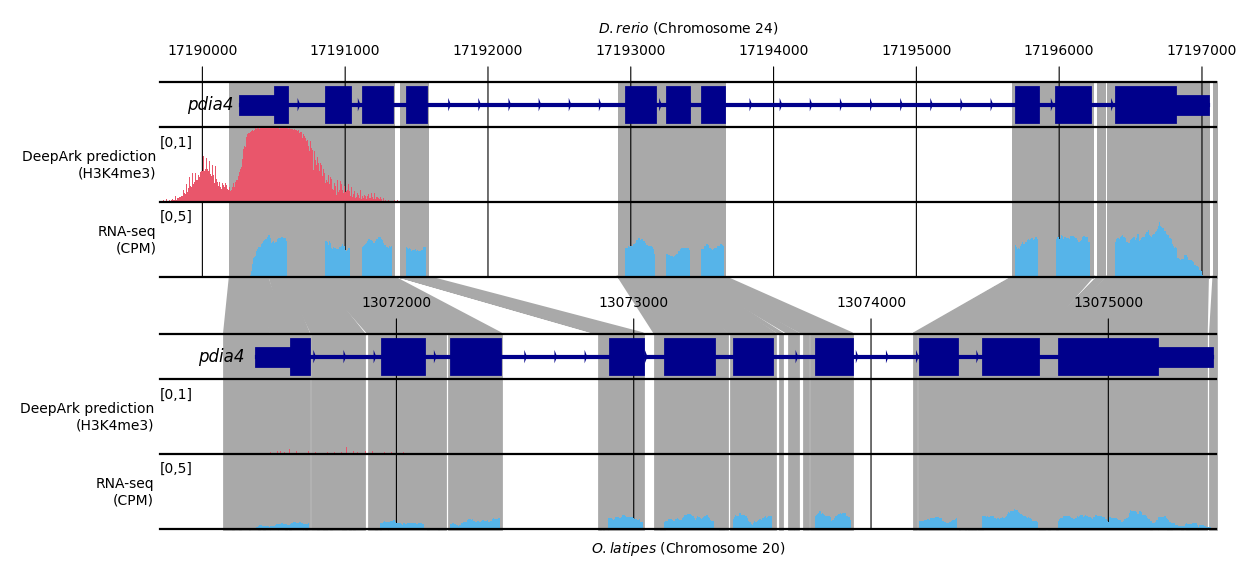

In [16]:
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
matplotlib.rcParams['xtick.major.size'] = 0
matplotlib.rcParams['xtick.major.width'] = 0.4
matplotlib.rcParams["figure.dpi"] = 200
matplotlib.rcParams["axes.facecolor"] = "none"
matplotlib.rcParams["xtick.labelsize"] = 5
matplotlib.rcParams["axes.labelsize"] = 5


step_size = 5
bs = 1000
unit_size = 5
rna_fc = "#56b4e9" # light blue
signal_fc = "#e9566b" # red
gene_fc = "darkblue"

# Make figure.
fig = plt.figure(figsize=(6,3), facecolor='w')
gridspec = matplotlib.gridspec.GridSpec(2, 1, figure=fig, height_ratios=[4, 4])
# fig = plt.figure(figsize=(9/2.54,5.75/2.54), facecolor='w')
# gridspec = matplotlib.gridspec.GridSpec(2, 1, figure=fig, height_ratios=[4, 4])

# Zebrafish plot.
ival1 = Interval("chr24", 17190210-500-5,17197050 + 50)

gf = "../data/danRer10.fa"
c_t = CoordinateTrack(genome_file=gf, bin_size=bs, tick_top=True, show_seq=False, show_spines=[], fontdict={'family': 'sans-serif', 'color':  'black', 'weight': 'normal', 'size': 6})
rna_t = SignalTrack("../interspecies_prediction/data/SRX3353221.CPM.bw", 
                   ylim=(0, 5), facecolor=rna_fc, show_spines=["bottom"],
                   step_size=step_size,
                   show_labels=False,
                   label='RNA-seq\n(CPM)',
                   fontdict={'family': 'sans-serif', 'color':  'black', 'weight': 'normal', 'size': unit_size})
t_t = TranscriptTrack("../interspecies_prediction/plot_data/danRer10.simple.sorted.gtf.gz", color=gene_fc, show_spines=["top", "bottom"])
chip_t = SignalTrack("../interspecies_prediction/outputs/danRer10.DCD000648SQ.bw", 
                     ylim=(0, 1), facecolor=signal_fc, show_spines=["bottom"],
                     show_labels=False,
                     step_size=step_size,
                     label='DeepArk prediction\n(H3K4me3)',
                     fontdict={'family': 'sans-serif', 'color':  'black', 'weight': 'normal', 'size': unit_size})
gv = GenomeViewer(tracks=[c_t, t_t, chip_t, rna_t])
axes1 = gv.plot(ival=ival1,
                fig=fig,
                subplotspec=gridspec[0],
                track_height_ratios=[1, 3, 5, 5],
                spacing=0.01)


# Medaka plot.
ival2 = Interval("chr20", 13071000+5, 13075455)
gf = "../data/oryLat2.fa"
c_t = CoordinateTrack(genome_file=gf, bin_size=bs, tick_top=True, show_seq=False, fontdict={'family': 'sans-serif', 'color':  'black', 'weight': 'normal', 'size': 6},
                      show_spines=[])
rna_t = SignalTrack("../interspecies_prediction/data/SRX3353227.CPM.bw", ylim=(0, 5), facecolor=rna_fc, show_spines=["bottom"],
                    show_labels=False,
                    step_size=step_size,
                    label='RNA-seq\n(CPM)',
                    fontdict={'family': 'sans-serif', 'color':  'black', 'weight': 'normal', 'size': unit_size})
t_t = TranscriptTrack("../interspecies_prediction/plot_data/oryLat2.simple.sorted.gtf.gz", color=gene_fc, show_spines=["top", "bottom"])
chip_t = SignalTrack("../interspecies_prediction/outputs/oryLat2.DCD000648SQ.bw", ylim=(0, 1), facecolor=signal_fc, show_spines=["bottom"], 
                      show_labels=False, 
                      step_size=step_size,
                      label='DeepArk prediction\n(H3K4me3)',
                      fontdict={'family': 'sans-serif', 'color':  'black', 'weight': 'normal', 'size': unit_size})
gv = GenomeViewer(tracks=[c_t, t_t, chip_t, rna_t])
axes2 = gv.plot(ival=ival2,
                fig=fig,
                subplotspec=gridspec[-1],
                track_height_ratios=[1, 3, 5, 5],
                spacing=0.01)

chain = Chain(chain_file=chain_file, chains=chains)
chain.plot(ival1, ival2, axes1, axes2, lw=1.5, palette=["darkgrey"])
axes2[-1].set_xlabel("$O. latipes$ (Chromosome 20)")
axes1[0].set_xlabel("$D. rerio$ (Chromosome 24)")
plt.subplots_adjust(right=0.88, left=0)
plt.show()
plt.close(fig)